#Kaggle Object Classification Final Project 
###Haley O'Reagan, Josephine Tsai, Joyce Fan

In [ ]:
# Import the necessary libraries
import math
import torch
import numpy as np  # Used in calculate_mean_std function
from torch.utils.data import DataLoader, TensorDataset  # Dataset
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms.transforms import Normalize
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Train model on a hardware accelerator like the GPU if it is available, otherwise continue to use the CPU
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


In [ ]:
# Displays output inline
%matplotlib inline

In [ ]:
# Authorize Colab to access Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Read datasets 
df_train = pd.read_csv("../content/drive/Shareddrives/Big Data Final Project/train.csv")
df_test = pd.read_csv("../content/drive/Shareddrives/Big Data Final Project/test.csv")

In [ ]:
# The first column is "label", columns from the 2nd to the last is "28 x 28 = 784 pixcels"
x_train = df_train.iloc[:,1:].values/255 # Normalize to improve accuracy
y_train = df_train.label.values          

In [ ]:
# Split train data into train_x, train_valid_x, train_y, train_valid_y by using sklearn's train_test_split.
train_x, train_valid_x, train_y, train_valid_y = train_test_split(x_train , y_train, test_size = 0.2, random_state = 42)

In [ ]:
# Convert the NumPy array to Torch Tensor so that we could use it in PyTorch
train_x_torch = torch.from_numpy(train_x).type(torch.FloatTensor)
valid_x_torch = torch.from_numpy(train_valid_x).type(torch.FloatTensor)
train_y_torch = torch.from_numpy(train_y).type(torch.LongTensor)
valid_y_torch = torch.from_numpy(train_valid_y).type(torch.LongTensor)

In [ ]:
# Redefine shape
train_x_torch = train_x_torch.view(-1, 1,28,28).float()
valid_x_torch = valid_x_torch.view(-1, 1,28,28).float()

In [ ]:
# Make tensor datasets
train_set = torch.utils.data.TensorDataset(train_x_torch, train_y_torch)
val_set = torch.utils.data.TensorDataset(valid_x_torch, valid_y_torch)

In [ ]:
# Load the data in batches
batch = 10
torch.manual_seed(20742)

load_train = DataLoader(train_set, batch_size=batch, shuffle=True) # set shuffle True to have the data reshuffled at every epoch
load_val = DataLoader(val_set, batch_size=batch, shuffle=False)

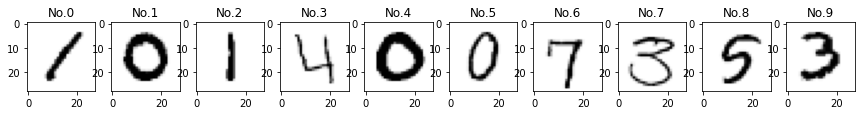

In [ ]:
# Plot training data
plt.figure(figsize=(30,30))
for i in range(10):
    plt.subplot(20, 20, i+1)
    plt.title("No." + str(i))
    plt.imshow(df_train.iloc[:,1:].iloc[i].values.reshape(28,28),cmap='Greys')

In [ ]:
# CNN model
class cnn_layers(nn.Module):
    def __init__(self):
        super(cnn_layers,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)  # Four hidden layers
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=2, stride=1)
        self.batchNorm2d1 = nn.BatchNorm2d(32) # Normalize batches with a mean around 0 and a variance of 1
        self.batchNorm2d2 = nn.BatchNorm2d(64)
        self.batchNorm2d3 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(256*2*2, 256) # Apply linear transformation to the incoming data
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) # ReLu activation for backpropogation at each layer
        x = self.batchNorm2d1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchNorm2d2(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batchNorm2d3(x)
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x) # Include dropouts to avoid overfitting
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

model = cnn_layers()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Define learning rate and optimizer
criterion = nn.CrossEntropyLoss() 

In [ ]:
# Train the model
process=[]
torch.manual_seed(20742)
error = nn.CrossEntropyLoss() # This criterion computes the cross entropy loss between input and target
epochs = 30
for epoch in range(epochs):
  running_loss = 0
  for images, labels in load_train:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = error(outputs, labels)
    optimizer.zero_grad() # Training pass
    loss.backward() # Learn by backpropagation
    optimizer.step() # Optimize weights
    # Using the variable 'running_loss' to store loss which would be calculated later
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_train:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      predictions = torch.max(outputs, 1)[1]
      # Using the variable 'correct' and 'total' to calculate the accauracy
      correct += (predictions == labels).sum()
      total += len(labels)
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')
    process.append(correct*100 / len(load_train.dataset))

Epoch 1/30 - loss: 0.02167477135545466 - accuracy: 0.98416668176651
Epoch 2/30 - loss: 0.005410802360823016 - accuracy: 0.9891071319580078
Epoch 3/30 - loss: 0.003819227749385786 - accuracy: 0.9902380704879761
Epoch 4/30 - loss: 0.0026818230572511464 - accuracy: 0.9947916269302368
Epoch 5/30 - loss: 0.0021511254391817303 - accuracy: 0.9957142472267151
Epoch 6/30 - loss: 0.001510968198909665 - accuracy: 0.9911606907844543
Epoch 7/30 - loss: 0.0012867096663373183 - accuracy: 0.9975892901420593
Epoch 8/30 - loss: 0.001234945096994034 - accuracy: 0.998035728931427
Epoch 9/30 - loss: 0.0010722824122885329 - accuracy: 0.998244047164917
Epoch 10/30 - loss: 0.0009304289888743668 - accuracy: 0.9977380633354187
Epoch 11/30 - loss: 0.000899494792927907 - accuracy: 0.9990476369857788
Epoch 12/30 - loss: 0.0007747382939304793 - accuracy: 0.9988988041877747
Epoch 13/30 - loss: 0.0006955635539055642 - accuracy: 0.9988095164299011
Epoch 14/30 - loss: 0.0006455974982992645 - accuracy: 0.998482108116149

No handles with labels found to put in legend.


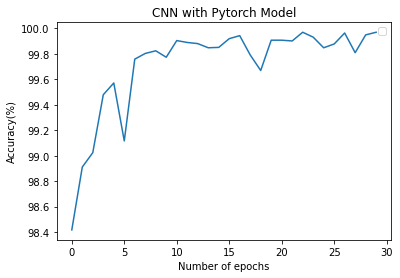

In [ ]:
# Plot accuracy
process = torch.tensor(process).cuda().data.cpu().numpy()
plt.plot(process)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy(%)")
plt.title("CNN with Pytorch Model")
plt.legend()
plt.show()

In [ ]:
count = 0
correct = 0
for images, labels in load_val:
    with torch.no_grad():
        model.eval() #deactivate dropouts layers, during model evaluation
        probs = model(images)
        preds = torch.max(probs, 1)[1]
    correct += (preds == labels).sum()
    count += len(labels)
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 8400 images - accuracy: 0.9942857027053833


##Test Data


In [ ]:
x_test = df_test.values/255
x_test_torch = torch.from_numpy(x_test).type(torch.FloatTensor)
d_labels = np.zeros(x_test.shape)
d_labels = torch.from_numpy(d_labels)
# Think about dimentions of data. Without this "an shapes doesn't fit error", will occur.
x_test_torch = x_test_torch.view(-1, 1, 28, 28)
# Make a tensordataset and a testloader
testset = torch.utils.data.TensorDataset(x_test_torch, d_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = False)

In [ ]:
# Create a list for submission
submit_list = [['ImageId', 'Label']]
with torch.no_grad():
    model.eval()
    id = 1
    for images,label in testloader:
        images,label = images.to(device), label.to(device)
        outputs = model(images)
        probs = torch.exp(outputs)
        top_p, top_class = probs.topk(1, dim = 1)
        for preds in top_class:
            submit_list.append([id,preds.item()])
            id += 1

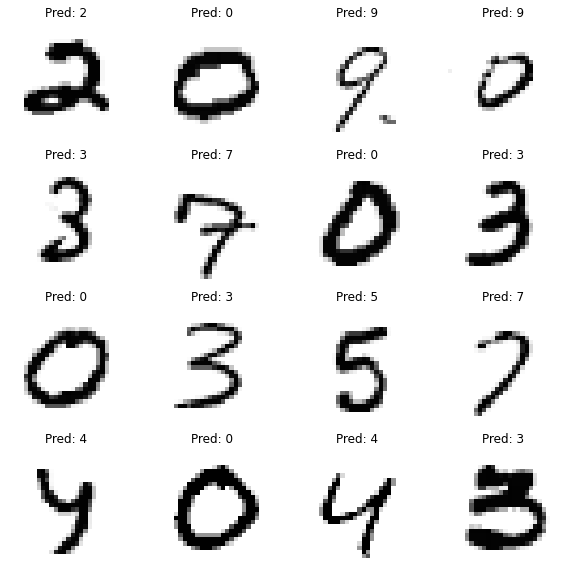

In [ ]:
# Plot images and predictions
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
i = 1
for ax in axs.reshape(-1):
    ax.set_title("Pred: %d" % (submit_list[i][1]))
    ax.imshow(df_test.iloc[i-1].values.reshape(28,28),cmap='Greys')
    ax.axis('off')
    i += 1

In [ ]:
# Save file
df = pd.DataFrame(submit_list)
df.columns = df.iloc[0]
df = df.drop(0, axis = 0)
df.to_csv('../content/drive/MyDrive/submit.csv', index = False)
print("submit.csv saved")

submit.csv saved
